<a href="https://colab.research.google.com/github/kushdondeti/COVID-19-Detection-with-Artificial-Intelligence-Machine-Learning/blob/main/covid_testing_original3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
def read_data(dataset_path='dataset'):
    data = []
    labels = []
    classes = os.listdir(dataset_path)
    for c in classes:
        images_path = os.listdir(os.path.join(dataset_path, c))
        for image_path in images_path:
            # resize the images
            image = cv2.imread(os.path.join(dataset_path, c, image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (299, 299))

            # store images and labels
            data.append(image)
            labels.append(c)

    data = np.array(data) / 255.
    labels = np.array(labels)

    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels)

    return data, labels, le.classes_

In [3]:
!cp -r /content/drive/MyDrive/AI_project ./

In [5]:
!unzip AI_project/dataset.zip

unzip:  cannot find or open AI_project/dataset.zip, AI_project/dataset.zip.zip or AI_project/dataset.zip.ZIP.


In [ ]:
data, labels, class_names = read_data()
print(data.shape)
print(labels.shape)

np.save('data.npy', data)
np.save('labels.npy', labels)

(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('class_names.npy', class_names)

(300, 299, 299, 3)
(300, 3)


In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
epochs = 10
bs = 8

# load the data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
class_names = np.load('class_names.npy')

In [ ]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
vgg = tf.keras.applications.VGG16(weights="imagenet",
									include_top=False,
									input_tensor=tf.keras.Input(shape=(299, 299, 3)))

# freeze the weights of VGG 16
vgg.trainable = False

# add some more layers to the feature extraction model
x = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(vgg.output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)

prediction = tf.keras.layers.Dense(3, activation="softmax")(x)

# build the final model
model = tf.keras.Model(inputs=vgg.input, outputs=prediction)

# show model architecture
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
______________________________________________________________

In [ ]:
# define loss and optimizer
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=1e-4), metrics=["accuracy"])

# train the model
training_history = model.fit(data_generator.flow(X_train, y_train, batch_size=bs),
							 steps_per_epoch=len(X_train) // bs,
							 validation_data=(X_test, y_test),
							 validation_steps=len(X_test) // bs,
							 epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
30/30 [==============================] - 230s 8s/step - loss: 0.8762 - accuracy: 0.6042 - val_loss: 0.7012 - val_accuracy: 0.6500
Epoch 2/10
30/30 [==============================] - 229s 8s/step - loss: 0.5662 - accuracy: 0.7125 - val_loss: 0.5476 - val_accuracy: 0.8000
Epoch 3/10
30/30 [==============================] - 229s 8s/step - loss: 0.4815 - accuracy: 0.7667 - val_loss: 0.4843 - val_accuracy: 0.8167
Epoch 4/10
30/30 [==============================] - 230s 8s/step - loss: 0.4878 - accuracy: 0.7458 - val_loss: 0.4679 - val_accuracy: 0.8333
Epoch 5/10
30/30 [==============================] - 231s 8s/step - loss: 0.4008 - accuracy: 0.8208 - val_loss: 0.4917 - val_accuracy: 0.7167
Epoch 6/10
30/30 [==============================] - 230s 8s/step - loss: 0.3902 - accuracy: 0.8083 - val_loss: 0.4411 - val_accuracy: 0.7667
Epoch 7/10
30/30 [==============================] - 230s 8s/step - loss: 0.3342 - accuracy: 0.8625 - val_loss: 0.4588 - val_accuracy: 0.7500
Epoch 8/10
30

In [ ]:
# make predictions on the test set
pred_test = model.predict(X_test, batch_size=bs)

# find labels for the test set
pred_test_label = np.argmax(pred_test, axis=1)

# show classification report
print(classification_report(y_test.argmax(axis=1), pred_test_label, target_names=class_names))

# compute the confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), pred_test_label))

              precision    recall  f1-score   support

     covid19       0.75      0.60      0.67        20
      normal       1.00      1.00      1.00        20
      others       0.67      0.80      0.73        20

    accuracy                           0.80        60
   macro avg       0.81      0.80      0.80        60
weighted avg       0.81      0.80      0.80        60

[[12  0  8]
 [ 0 20  0]
 [ 4  0 16]]


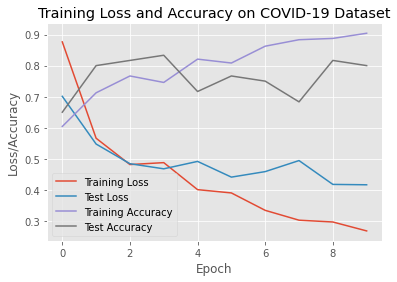

In [ ]:
# plot the training and test loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), training_history.history["loss"], label="Training Loss")
plt.plot(np.arange(0, epochs), training_history.history["val_loss"], label="Test Loss")
plt.plot(np.arange(0, epochs), training_history.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, epochs), training_history.history["val_accuracy"], label="Test Accuracy")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.savefig("plot1.png")

In [ ]:
model.save("covid19_detector1.h5")

In [ ]:
# unfreeze the weights of model
inception.trainable = True
set_trainable = False

for layer in inception.layers:
    if layer.name == 'conv2d_185':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


# define loss and optimizer
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=["accuracy"])
epochs = epochs // 2
# train the model
training_history = model.fit(data_generator.flow(X_train, y_train, batch_size=bs),
							 steps_per_epoch=len(X_train) // bs,
							 validation_data=(X_test, y_test),
							 validation_steps=len(X_test) // bs,
							 epochs=5)

In [ ]:
# make predictions on the test set
pred_test = model.predict(X_test, batch_size=bs)

# find labels for the test set
pred_test_label = np.argmax(pred_test, axis=1)

# show classification report
print(classification_report(y_test.argmax(axis=1), pred_test_label, target_names=class_names))

# compute the confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), pred_test_label))

In [ ]:
# plot the training and test loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), training_history.history["loss"], label="Training Loss")
plt.plot(np.arange(0, epochs), training_history.history["val_loss"], label="Test Loss")
plt.plot(np.arange(0, epochs), training_history.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, epochs), training_history.history["val_accuracy"], label="Test Accuracy")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.savefig("plot2.png")

In [ ]:
# save model
model.save("covid19_detector.h5")